<a href="https://colab.research.google.com/github/gsilsbe/Missouri_Reservoirs/blob/main/MDN_TN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [4]:
# Delete the MDN package folder (removes the corrupted file)
!rm -rf /usr/local/lib/python3.12/dist-packages/MDN
!rm -rf /usr/local/lib/python3.12/dist-packages/MDN-*

In [5]:
# Install MDN (code only, no dependencies)
!pip install -q git+https://github.com/BrandonSmithJ/MDN@ae1626c7990436d512044fa878f6bf276b5ce20d --no-deps

import MDN
print("MDN installed from:", MDN.__file__)

  Preparing metadata (setup.py) ... done
MDN installed from: /usr/local/lib/python3.12/dist-packages/MDN/__init__.py


In [6]:
# Upload files in colab
from google.colab import files
uploaded = files.upload()

Saving product_estimation.py to product_estimation.py
Saving MDN.py to MDN.py


In [7]:
# Rename the uploaded files so they don’t shadow the package
import os

if "MDN.py" in uploaded:
    os.rename("/content/MDN.py", "/content/MDN_custom.py")

if "product_estimation.py" in uploaded:
    os.rename("/content/product_estimation.py", "/content/product_estimation_custom.py")

In [8]:
# Import the MDN package and locate its installation folder
import MDN, os

print("MDN package root:", os.path.dirname(MDN.__file__))

mdn_pkg_dir = os.path.dirname(MDN.__file__)
mdn_model_dir = os.path.join(mdn_pkg_dir, "model")
mdn_pkg_dir, mdn_model_dir

MDN package root: /usr/local/lib/python3.12/dist-packages/MDN


('/usr/local/lib/python3.12/dist-packages/MDN',
 '/usr/local/lib/python3.12/dist-packages/MDN/model')

In [9]:
# Overwrite the package files with your custom versions
import shutil

# Overwrite MDN/model/MDN.py with your custom file
shutil.copy("/content/MDN_custom.py",
            os.path.join(mdn_model_dir, "MDN.py"))

# Overwrite MDN/product_estimation.py with your custom file
shutil.copy("/content/product_estimation_custom.py",
            os.path.join(mdn_pkg_dir, "product_estimation.py"))

'/usr/local/lib/python3.12/dist-packages/MDN/product_estimation.py'

In [11]:
# Reload the modules so Python sees your patched code
import importlib

mdn_module = importlib.import_module("MDN.model.MDN")
product_estimation_module = importlib.import_module("MDN.product_estimation")

importlib.reload(mdn_module)
importlib.reload(product_estimation_module)

print("Using MDN from:", mdn_module.__file__)
print("Using product_estimation from:", product_estimation_module.__file__)

Using MDN from: /usr/local/lib/python3.12/dist-packages/MDN/model/MDN.py
Using product_estimation from: /usr/local/lib/python3.12/dist-packages/MDN/product_estimation.py


In [12]:
import numpy as np
import tensorflow as tf

import MDN.model.utils as mdn_utils
import MDN.model.MDN as mdn_module

def ensure_format_safe(arr):
    """
    Safer version of ensure_format that can handle:
    - numpy arrays
    - lists
    - tf.Tensors (eager or symbolic)
    """
    # If it's a TensorFlow tensor
    if isinstance(arr, tf.Tensor):
        # Try to convert eager tensors to numpy
        try:
            arr = arr.numpy()
        except Exception:
            # If it's symbolic, just cast to float32 tensor and return
            # (this keeps TF happy inside graphs; sklearn scalers won't see this)
            return tf.cast(arr, tf.float32)

    # Normal path: make sure we have a 2D float32 numpy array
    arr = np.array(arr)
    if arr.ndim == 1:
        arr = arr[:, None]
    return arr.astype(np.float32)

# Patch ensure_format in both modules:
mdn_utils.ensure_format = ensure_format_safe
mdn_module.ensure_format = ensure_format_safe

print("✅ Patched ensure_format in MDN.model.utils and MDN.model.MDN")

✅ Patched ensure_format in MDN.model.utils and MDN.model.MDN


In [13]:
import importlib
from MDN import product_estimation, image_estimates, get_tile_data, get_sensor_bands
from MDN.product_estimation import get_estimates
from MDN.utils import split_data
from MDN.transformers import LogTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
print("All imports worked!")

All imports worked!


In [14]:
# --- Co-located WQ dataset
wq_rrs = pd.read_csv("df_polygon_wq.csv", header=0).sort_values(by='Date')
wq_rrs = wq_rrs[wq_rrs['Date'].notna()]  # remove NAs
print(wq_rrs[:3])

     Reservoir        Date Sensor  Rrs_443   Rrs_479  Rrs_482  Rrs_483  \
469         72  2000-06-25     L7      NaN  0.004212      NaN      NaN   
470         72  2000-08-28     L7      NaN  0.004856      NaN      NaN   
344         92  2000-09-13     L7      NaN  0.002036      NaN      NaN   

      Rrs_561  Rrs_592  Rrs_594  ...  ecoregionID                EPA_L3NAME  \
469  0.010124      NaN      NaN  ...          6.0  Western Corn Belt Plains   
470  0.011714      NaN      NaN  ...          6.0  Western Corn Belt Plains   
344  0.005027      NaN      NaN  ...          3.0           Ozark Highlands   

       landCover     urban     forest  grassland    pasture       crop  \
469  agriculture  5.920592  13.321332   0.160016  39.873987  32.593259   
470  agriculture  5.920592  13.321332   0.160016  39.873987  32.593259   
344  agriculture  7.051410  36.827365   0.100020  52.200440   1.090218   

     agriculture   wetland  
469    72.467247  2.060206  
470    72.467247  2.060206  
34

In [15]:
wq_rrs.keys()

Index(['Reservoir', 'Date', 'Sensor', 'Rrs_443', 'Rrs_479', 'Rrs_482',
       'Rrs_483', 'Rrs_561', 'Rrs_592', 'Rrs_594', 'Rrs_613', 'Rrs_654',
       'Rrs_655', 'Rrs_661', 'Rrs_720', 'Rrs_835', 'Rrs_865', 'Rrs_1608',
       'Rrs_1609', 'Rrs_1650', 'Rrs_2201', 'Rrs_2208', 'Flag', 'Flag_decoded',
       'Flag_percentages', 'reservoir_id', 'extraction_type', 'MULakeNumber',
       'Hylak_id', 'waterBody', 'samplingSite', 'Year', 'Month', 'Day',
       'depthCat', 'waterBodyLatitude', 'waterBodyLongitude', 'CHL_A_lab',
       'SECCHI', 'TN', 'TP', 'TSS', 'ecoregionID', 'EPA_L3NAME', 'landCover',
       'urban', 'forest', 'grassland', 'pasture', 'crop', 'agriculture',
       'wetland'],
      dtype='object')

Landsat 7
- Blue Band: Band 1 (0.45–0.52 µm)
- Green Band: Band 2 (0.52–0.60 µm)
- Red Band: Band 3 (0.63–0.69 µm)
- NIR: Band 4 (0.77–0.90 µm)

Landsat 8 and 9 (Operational Land Imager - OLI)
- Blue Band: Band 2 (0.45–0.51 µm)
- Green Band: Band 3 (0.53–0.59 µm)
- Red Band: Band 4 (0.64–0.67 µm)
- NIR: Band 5 (0.77–0.90 µm)

Sensor_bands
- 'L7': [479, 561, 661, 720, 835, 1650, 2201, 2208],
- 'L8': [443, 483, 561, 592, 613, 655, 865, 1609, 2201]
- 'L9': [443, 482, 561, 594, 613, 654, 865, 1608, 2201]

In [16]:
# Define the generic band order
max_bands = 4  # max number of bands MDN will see

generic_cols = [f'Rrs_{i+1}' for i in range(max_bands)]

# Map sensor-specific bands to generic columns
sensor_bands = {
    'L7': [479, 561, 661, 835],
    'L8': [483, 561, 655, 865],
    'L9': [482, 561, 654, 865]
}

def rename_bands(row):
    sensor = row['Sensor']
    bands = sensor_bands[sensor]
    rrs_cols = [f'Rrs_{b}' for b in bands]

    # Create a row with generic columns
    new_row = pd.Series(index=generic_cols, dtype=float)

    for i, col in enumerate(rrs_cols):
        if i < len(generic_cols):
            new_row[generic_cols[i]] = row[col]

    return new_row

df_generic = wq_rrs.apply(rename_bands, axis=1)

# Combine with other info
df1 = pd.concat([wq_rrs[['MULakeNumber', 'Hylak_id','waterBody', 'samplingSite',
                         'Date', 'depthCat','waterBodyLatitude', 'waterBodyLongitude',
                         'ecoregionID', 'urban', 'forest', 'grassland', 'pasture', 'crop',
                         'agriculture', 'wetland', 'Sensor',
                         'CHL_A_lab', 'SECCHI', 'TN','TP', 'TSS']], df_generic], axis=1)
print(df1)

     MULakeNumber  Hylak_id           waterBody          samplingSite  \
469            72    9219.0          Smithville          Smithville 1   
470            72    9219.0          Smithville          Smithville 1   
344            92    9268.0      Pomme De Terre      Pomme de Terre 1   
115           149     797.0  Lake of the Ozarks  Lake of the Ozarks 1   
345            92    9268.0      Pomme De Terre      Pomme de Terre 1   
..            ...       ...                 ...                   ...   
569            89     796.0              Truman              Truman 1   
558            89     796.0              Truman              Truman 1   
498            72    9219.0          Smithville          Smithville 1   
499            72    9219.0          Smithville          Smithville 1   
334            30    9294.0          Wappapello          Wappapello 1   

           Date depthCat  waterBodyLatitude  waterBodyLongitude  ecoregionID  \
469  2000-06-25     surf            39.3975

In [17]:
df1.keys()

Index(['MULakeNumber', 'Hylak_id', 'waterBody', 'samplingSite', 'Date',
       'depthCat', 'waterBodyLatitude', 'waterBodyLongitude', 'ecoregionID',
       'urban', 'forest', 'grassland', 'pasture', 'crop', 'agriculture',
       'wetland', 'Sensor', 'CHL_A_lab', 'SECCHI', 'TN', 'TP', 'TSS', 'Rrs_1',
       'Rrs_2', 'Rrs_3', 'Rrs_4'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MinMaxScaler

# 1. Select TN and Rrs columns
var_col = df1.columns.str.contains('TN')
rrs_col = df1.columns.str.contains('Rrs_')
cat_col = ['ecoregionID', 'urban', 'forest', 'grassland', 'pasture', 'crop', 'agriculture','wetland']

# Create a boolean mask for categorical columns
cat_col_mask = df1.columns.isin(cat_col)

# Combine all boolean masks using logical OR to ensure correct length
all_col = var_col | rrs_col | cat_col_mask
df_tn_rrs = df1.loc[:, all_col]

# 2. Keep rows where TN > 0
df_tn_rrs = df_tn_rrs[df_tn_rrs['TN'] > 0]

# 3. Drop rows with any NaN values
df_tn_rrs = df_tn_rrs.dropna()

# 4. Check valid Rrs counts
print((df_tn_rrs.iloc[:, 1:] > 0).sum(axis=0))

# 5. Inspect before normalization
print("\nBefore normalization:")
print(df_tn_rrs.describe())

urban          496
forest         496
grassland      489
pasture        496
crop           418
agriculture    496
wetland        494
TN             496
Rrs_1          496
Rrs_2          496
Rrs_3          496
Rrs_4          496
dtype: int64

Before normalization:
       ecoregionID       urban      forest   grassland     pasture  \
count   496.000000  496.000000  496.000000  496.000000  496.000000   
mean      2.657258   10.683044   39.104454    0.306644   28.942156   
std       1.398220   13.999152   24.747007    0.423851   16.080297   
min       1.000000    1.870000    2.650000    0.000000    0.069993   
25%       2.000000    4.819518   17.030000    0.159984   16.600000   
50%       3.000000    5.219478   35.716428    0.209958   28.930000   
75%       3.000000    9.070907   62.037592    0.300030   39.873987   
max       6.000000   81.446289   94.391122    8.030000   74.007401   

             crop  agriculture     wetland          TN       Rrs_1  \
count  496.000000   496.000000  496

In [19]:
import numpy as np

# Define the categorical columns again for clarity in this cell
cat_col = ['ecoregionID', 'urban', 'forest', 'grassland', 'pasture', 'crop', 'agriculture','wetland']

# 1. Prepare X (features) and y (target)
rrs_cols = df_tn_rrs.columns[df_tn_rrs.columns.str.contains('Rrs_')].tolist()
feature_cols = rrs_cols + cat_col
X = df_tn_rrs[feature_cols].to_numpy()
y = df_tn_rrs['TN'].to_numpy()

# 2. Split data
# n_train can be fraction (0-1) or absolute number of samples
(x_train, y_train), (x_test, y_test) = split_data(X, y, n_train=0.8)

# Check shapes
print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
(396, 12)
(396,)
(100, 12)
(100,)


In [20]:
print(feature_cols)

['Rrs_1', 'Rrs_2', 'Rrs_3', 'Rrs_4', 'ecoregionID', 'urban', 'forest', 'grassland', 'pasture', 'crop', 'agriculture', 'wetland']


In [21]:
print("\n--- x_train ---")
print("Shape:", x_train.shape)
print("Data type:", x_train.dtype)
print("First 5 rows:\n", x_train[:5])

print("\n--- y_train ---")
print("Shape:", y_train.shape)
print("Data type:", y_train.dtype)
print("First 5 values:\n", y_train[:5])

print("\n--- x_test ---")
print("Shape:", x_test.shape)
print("Data type:", x_test.dtype)
print("First 5 rows:\n", x_test[:5])

print("\n--- y_test ---")
print("Shape:", y_test.shape)
print("Data type:", y_test.dtype)
print("First 5 values:\n", y_test[:5])


--- x_train ---
Shape: (396, 12)
Data type: float64
First 5 rows:
 [[4.47870465e-03 9.54009779e-03 6.78616483e-03 5.10352477e-03
  1.00000000e+00 4.83951605e+00 2.02679732e+01 1.99980002e-01
  5.07149285e+01 1.50684932e+01 6.57834217e+01 3.13968603e+00]
 [9.09111090e-03 8.98551196e-03 4.51122085e-03 4.76121996e-03
  3.00000000e+00 1.17700000e+01 6.96100000e+01 1.70000000e-01
  1.66000000e+01 0.00000000e+00 1.66000000e+01 1.10000000e-01]
 [7.78329372e-03 9.40213539e-03 5.39182872e-03 3.72583931e-03
  3.00000000e+00 7.05141028e+00 3.68273655e+01 1.00020004e-01
  5.22004401e+01 1.09021804e+00 5.32906581e+01 3.90078016e-01]
 [5.05056139e-03 1.05619179e-02 2.83286744e-03 2.28239689e-03
  3.00000000e+00 3.73962604e+00 8.78212179e+01 1.59984002e-01
  6.35936406e+00 8.99910009e-02 6.44935506e+00 7.39926007e-01]
 [1.22154905e-02 1.27072940e-02 8.27473309e-03 7.97794666e-03
  3.00000000e+00 4.81951805e+00 3.76962304e+01 8.49915008e-01
  3.31666833e+01 1.06689331e+01 4.38356164e+01 4.00959904e+0

(array([ 80., 149.,  67.,  37.,  31.,  13.,  12.,   4.,   2.,   1.]),
 array([  7.13775874,  28.83654532,  50.53533191,  72.23411849,
         93.93290507, 115.63169165, 137.33047823, 159.02926481,
        180.72805139, 202.42683797, 224.12562455]),
 <BarContainer object of 10 artists>)

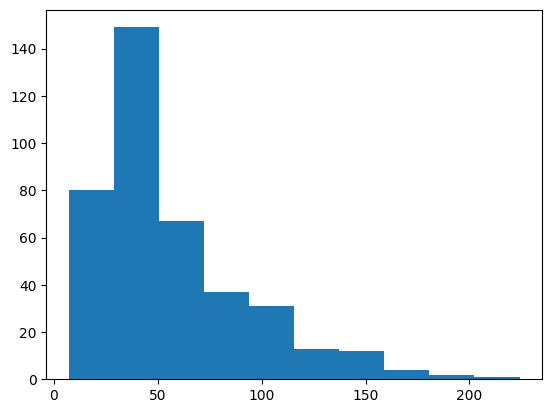

In [22]:
#plt.hist(y_train)
plt.hist(y_train)

### **Run MDN**

In [23]:
pipe = Pipeline([
    ('log', LogTransformer()),                           # handles TN log-transform
    ('robust', RobustScaler()),                          # robust scaling
    ('minmax', MinMaxScaler(feature_range=(-1, 1)))      # scales Rrs to -1 to 1
])

In [24]:
class args:
    verbose = False
    sensor = 'OLI'  # Landsat 8
    wavelength = 483, 561, 655, 865
    wavelengths = 483, 561, 655, 865
    bands = 483, 561, 655, 865  # Landsat 8 bands: 443, 483, 561, 592, 613, 655, 865, 1609, 2201

    use_kbest = 0
    use_ratio = 0
    use_auc = 0
    use_excl_Rrs = 0
    no_all_ratio = 0
    model_loc = 'MO_TN'
    model_lbl = 'MO_TN'

    n_rounds = 10
    silent = True
    seed = 10
    use_bagging = 1

    n_mix = 3                              # Number of mixtures used in the Gaussian mixture model. Fewer mixtures = faster, smoother outputs, less flexibility. More mixtures = better for multimodal data (e.g., if TN distributions vary strongly among lakes).
    hidden = [100, 100, 100, 100, 100]     # Layers and units
    n_hidden = 100                         # Neurons per layer. 64
    n_layers = 5                           # shallow

    imputations = 10
    lr = 1e-4                              # Learning rate
    l2 = 1e-4                              # L2 regularization
    n_iter = int(10000)                      # Training iterations - must be an integer (not float)
    batch = 128
    epsilon = 1e-4
    activation = 'relu'                    # "relu", "elu" or "tanh"

    scalerx = 'TransformerPipeline'        # Rrs will be scaled/logged inside the model
    scalery = 'TransformerPipeline'        # TN will be log-transformed + scaled inside the model
    model_path = 'Weights'
    model_name = 'MO_TN'

    no_load = True
    no_save = False


my_args = args()

In [25]:
my_args.CI = 0.9  # e.g., 90% confidence

In [26]:
my_mdn = get_estimates(
    my_args,
    x_train, y_train,
    x_test, y_test,
    return_model=True, return_coefs=True
)


✅ 297 train, 99 val (bagging mode)


NotImplementedError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/MDN/model/MDN.py", line 238, in fit  *
        self.scalerx.fit( ensure_format(X), ensure_format(Y) )
    File "/usr/local/lib/python3.12/dist-packages/MDN/model/utils.py", line 20, in ensure_format  *
        arr = np.array(arr).copy().astype(np.float32)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (y:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [22]:
my_mdn

NameError: name 'my_mdn' is not defined

📊 10 rounds, 100 samples each


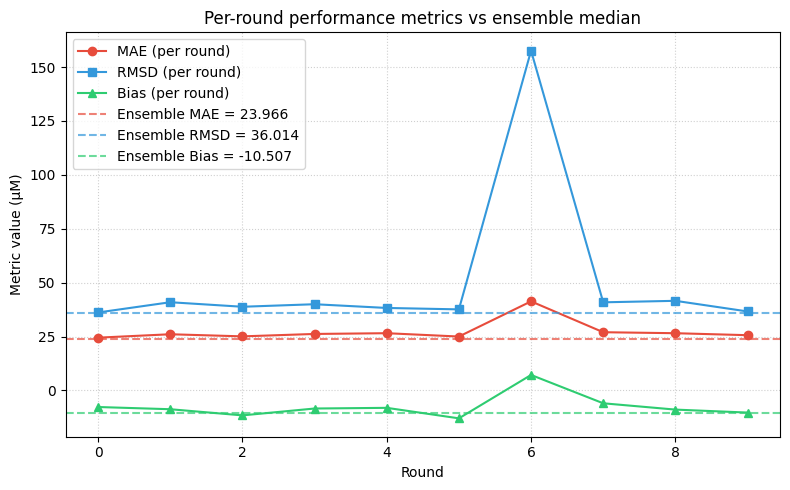

Best single round = 0 (MAE=24.474, RMSD=36.157, Bias=-7.692)
Ensemble median   = MAE=23.966, RMSD=36.014, Bias=-10.507


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Unpack outputs
# --------------------------------------------------
outputs = my_mdn[0] if isinstance(my_mdn, tuple) else my_mdn
all_estimates = np.stack(outputs["estimates"], axis=0)

# Flatten if output has an extra dim
if all_estimates.ndim == 3:
    all_estimates = all_estimates.squeeze(-1)

n_rounds, n_samples = all_estimates.shape
print(f"📊 {n_rounds} rounds, {n_samples} samples each")

# --------------------------------------------------
# Per-round metrics
# --------------------------------------------------
mae_list, rmsd_list, bias_list = [], [], []
for i, est in enumerate(all_estimates):
    res = y_test - est
    mae  = np.mean(np.abs(res))
    rmsd = np.sqrt(np.mean(res**2))
    bias = np.mean(est - y_test)
    mae_list.append(mae)
    rmsd_list.append(rmsd)
    bias_list.append(bias)

# --------------------------------------------------
# Ensemble median metrics
# --------------------------------------------------
ensemble_median = np.median(all_estimates, axis=0)
res_med = y_test - ensemble_median
mae_med  = np.mean(np.abs(res_med))
rmsd_med = np.sqrt(np.mean(res_med**2))
bias_med = np.mean(ensemble_median - y_test)

# --------------------------------------------------
# Plot — metrics across rounds
# --------------------------------------------------
plt.figure(figsize=(8,5))

# define consistent colors
colors = {'MAE': '#E74C3C', 'RMSD': '#3498DB', 'Bias': '#2ECC71'}

plt.plot(range(n_rounds), mae_list,  'o-', color=colors['MAE'],  label='MAE (per round)')
plt.plot(range(n_rounds), rmsd_list, 's-', color=colors['RMSD'], label='RMSD (per round)')
plt.plot(range(n_rounds), bias_list, '^-', color=colors['Bias'], label='Bias (per round)')

# ensemble reference lines (same color, dashed)
plt.axhline(mae_med,  color=colors['MAE'],  linestyle='--', alpha=0.7, label=f'Ensemble MAE = {mae_med:.3f}')
plt.axhline(rmsd_med, color=colors['RMSD'], linestyle='--', alpha=0.7, label=f'Ensemble RMSD = {rmsd_med:.3f}')
plt.axhline(bias_med, color=colors['Bias'], linestyle='--', alpha=0.7, label=f'Ensemble Bias = {bias_med:.3f}')

plt.xlabel("Round")
plt.ylabel("Metric value (µM)")
plt.title("Per-round performance metrics vs ensemble median")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Print Summary
# --------------------------------------------------
best_idx = np.argmin(mae_list)
print(f"Best single round = {best_idx} "
      f"(MAE={mae_list[best_idx]:.3f}, RMSD={rmsd_list[best_idx]:.3f}, Bias={bias_list[best_idx]:.3f})")
print(f"Ensemble median   = MAE={mae_med:.3f}, RMSD={rmsd_med:.3f}, Bias={bias_med:.3f}")



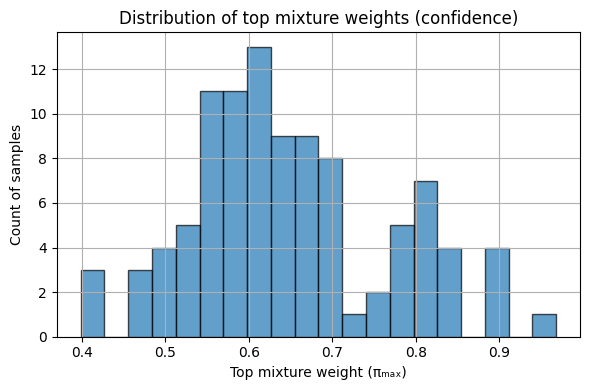

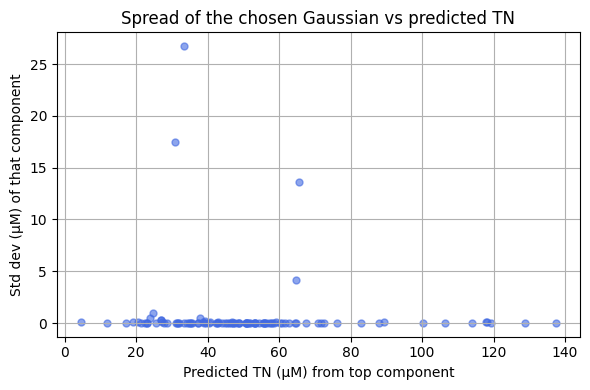

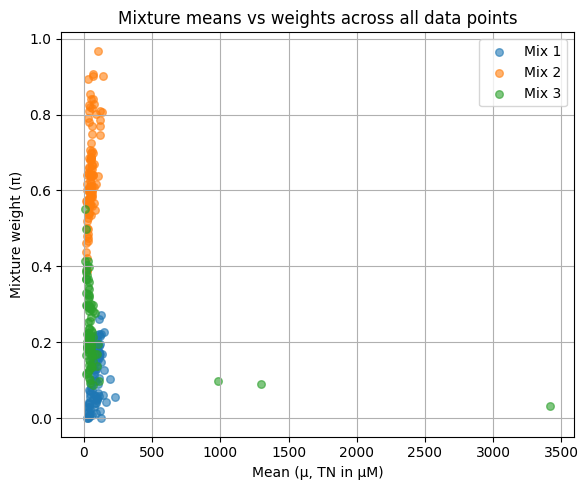

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==================================================
# 1️⃣ Ensemble median + CI across all training rounds
# ==================================================
outputs = my_mdn[0] if isinstance(my_mdn, tuple) else my_mdn

# ==================================================
# 2️⃣ Mixture component diagnostics (select trained model)
# ==================================================
trained_model = outputs["model"][2]  # last trained model

# Run forward pass to get mixture coefficients
_, coefs = trained_model.predict(
    x_test,
    return_coefs=True,
    chunk_size=1e5,
    use_gpu=False
)

# Unpack
priors, mus, sigmas = coefs   # shapes:
# priors: (N, n_mix)
# mus:    (N, n_mix, 1)
# sigmas: (N, n_mix, 1, 1)

mus    = mus.squeeze(-1)                     # (N, n_mix)
sigmas = sigmas.squeeze(-1).squeeze(-1)      # (N, n_mix)

# --------------------------------------------------
# Convert mus and sigmas to real (unscaled) TN values
# --------------------------------------------------
# Inverse-transform μ (mean)
mus_flat = mus.reshape(-1, 1)
mus_real_flat = trained_model.scalery.inverse_transform(mus_flat)
mus_real = mus_real_flat.reshape(mus.shape)

# Compute physical-unit scaling for σ
test = np.zeros_like(mus_flat)
test_plus1 = np.zeros_like(mus_flat) + 1
scale_diff = trained_model.scalery.inverse_transform(test_plus1) - trained_model.scalery.inverse_transform(test)
scale_factor = np.mean(scale_diff)  # ≈ std in µM
sigmas_real = sigmas * scale_factor  # now σ in µM

# --------------------------------------------------
# Identify dominant mixture for each sample
# --------------------------------------------------
top_component_idx = np.argmax(priors, axis=1)
top_component_w   = np.max(priors, axis=1)
top_component_mu  = mus_real[np.arange(len(mus)), top_component_idx]
top_component_std = sigmas_real[np.arange(len(sigmas_real)), top_component_idx]

# --------------------------------------------------
# Plot 1 — Distribution of dominant mixture weights
# --------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(top_component_w, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Top mixture weight (πₘₐₓ)")
plt.ylabel("Count of samples")
plt.title("Distribution of top mixture weights (confidence)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Plot 2 — σ vs μ for top Gaussian (correctly scaled)
# --------------------------------------------------
plt.figure(figsize=(6,4))
plt.scatter(top_component_mu, top_component_std,
            alpha=0.6, s=25, color='royalblue')
plt.xlabel("Predicted TN (µM) from top component")
plt.ylabel("Std dev (µM) of that component")
plt.title("Spread of the chosen Gaussian vs predicted TN")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Plot 3 — μ vs π across all mixtures
# --------------------------------------------------
plt.figure(figsize=(6,5))
for k in range(priors.shape[1]):
    plt.scatter(mus_real[:, k], priors[:, k], s=30, alpha=0.6, label=f"Mix {k+1}")

plt.xlabel("Mean (μ, TN in µM)")
plt.ylabel("Mixture weight (π)")
plt.title("Mixture means vs weights across all data points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best single round = 0 (MAE = 24.474)


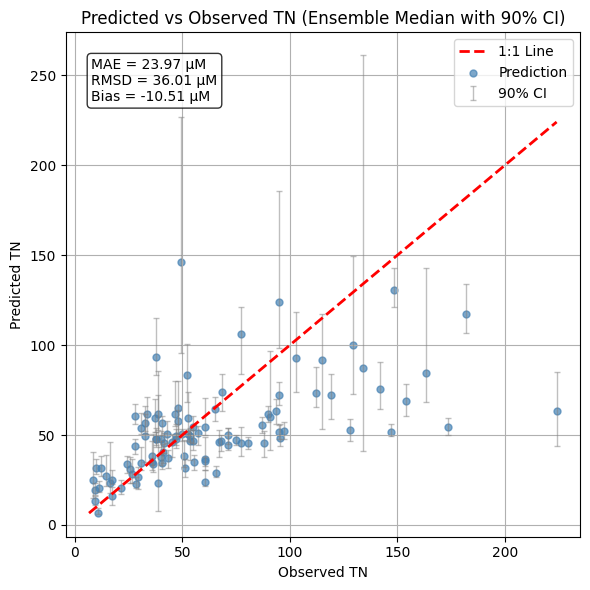

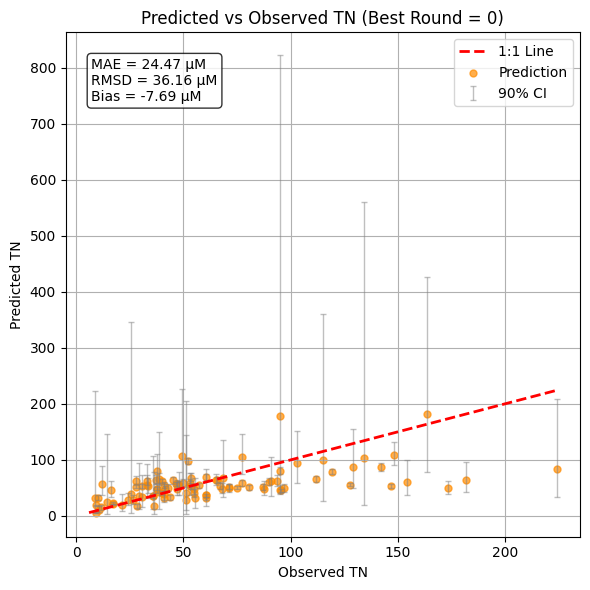

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# unpack from get_estimates(...)
outputs = my_mdn[0] if isinstance(my_mdn, tuple) else my_mdn

# pull arrays from outputs
estimates    = np.stack(outputs["estimates"], axis=0)      # (n_rounds, N, 1)
upper_bounds = np.stack(outputs["upper_bound"], axis=0)    # (n_rounds, N, 1)
lower_bounds = np.stack(outputs["lower_bound"], axis=0)    # (n_rounds, N, 1)

# flatten if needed
if estimates.ndim == 3:
    estimates = estimates.squeeze(-1)
    upper_bounds = upper_bounds.squeeze(-1)
    lower_bounds = lower_bounds.squeeze(-1)

n_rounds, n_samples = estimates.shape
y_true = y_test.flatten()

# ---------------------------------------------
# Compute MAE per round → find best round index
# ---------------------------------------------
mae_per_round = [np.mean(np.abs(y_true - est)) for est in estimates]
best_round = np.argmin(mae_per_round)
print(f"Best single round = {best_round} (MAE = {mae_per_round[best_round]:.3f})")

# ---------------------------------------------
# Median ensemble
# ---------------------------------------------
pred_median = np.median(estimates, axis=0)
upper_median = np.median(upper_bounds, axis=0)
lower_median = np.median(lower_bounds, axis=0)

# for the best round
pred_best = estimates[best_round]
upper_best = upper_bounds[best_round]
lower_best = lower_bounds[best_round]

# compute error bars
def err_bars(pred, upper, lower):
    return np.vstack([pred - lower, upper - pred])

# ---------------------------------------------
# helper function for plotting
# ---------------------------------------------
def plot_pred_vs_obs(y_true, pred, upper, lower, title, color):
    plt.figure(figsize=(6,6))
    yerr = err_bars(pred, upper, lower)
    plt.scatter(y_true, pred, s=25, alpha=0.7, color=color, label="Prediction")
    plt.errorbar(y_true, pred, yerr=yerr, fmt='none', ecolor='gray', alpha=0.5, elinewidth=1, capsize=2, label="90% CI")

    min_val = min(y_true.min(), pred.min())
    max_val = max(y_true.max(), pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 Line')

    res = y_true - pred
    mae = np.mean(np.abs(res))
    rmsd = np.sqrt(np.mean(res**2))
    bias = np.mean(pred - y_true)

    plt.text(0.05, 0.95,
             f"MAE = {mae:.2f} µM\n"
             f"RMSD = {rmsd:.2f} µM\n"
             f"Bias = {bias:.2f} µM",
             transform=plt.gca().transAxes,
             va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel("Observed TN")
    plt.ylabel("Predicted TN")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------
# Plot both ensemble median and best single round
# ---------------------------------------------
plot_pred_vs_obs(y_true, pred_median, upper_median, lower_median,
                 "Predicted vs Observed TN (Ensemble Median with 90% CI)",
                 color='steelblue')

plot_pred_vs_obs(y_true, pred_best, upper_best, lower_best,
                 f"Predicted vs Observed TN (Best Round = {best_round})",
                 color='darkorange')




## mean absolute error and bias

In [ ]:
estimates = my_mdn[0]['estimates']
n = np.shape(estimates)[0]
x = np.shape(estimates)[1]
print(n,x)
print(np.shape(x_test))
estimates = np.zeros([n,x])
for i in range(n):
    estimates[i,:] = my_mdn[0]['estimates'][i].flatten()

10 100
(100, 4)


In [ ]:
# 1. Predicted values
predicted = np.median(estimates, axis=0)

# 2. Linear-space metrics (TN already in µM)
res_lin = y_test - predicted
mae_lin = np.mean(np.abs(res_lin))                  # mean absolute error in TN units
rmsd_lin = np.sqrt(np.mean(res_lin**2))             # root mean squared difference in TN units
bias_lin = np.mean(predicted - y_test)             # additive bias in TN units

print(f"Linear-space: MAE = {mae_lin:.3f} µM, RMSD = {rmsd_lin:.3f} µM, Bias = {bias_lin:.3f} µM")

# 3. Log-space metrics (Seegers et al., 2018)
residuals_log = np.log10(y_test) - np.log10(predicted)
bias_log = 10**residuals_log.mean()                # multiplicative bias factor
mae_log = 10**np.abs(residuals_log).mean()        # multiplicative MAE factor

print(f"Log-space: MAE factor = {mae_log:.3f}, Multiplicative bias = {bias_log:.3f}")

Linear-space: MAE = 23.966 µM, RMSD = 36.014 µM, Bias = -10.507 µM
Log-space: MAE factor = 1.490, Multiplicative bias = 1.067


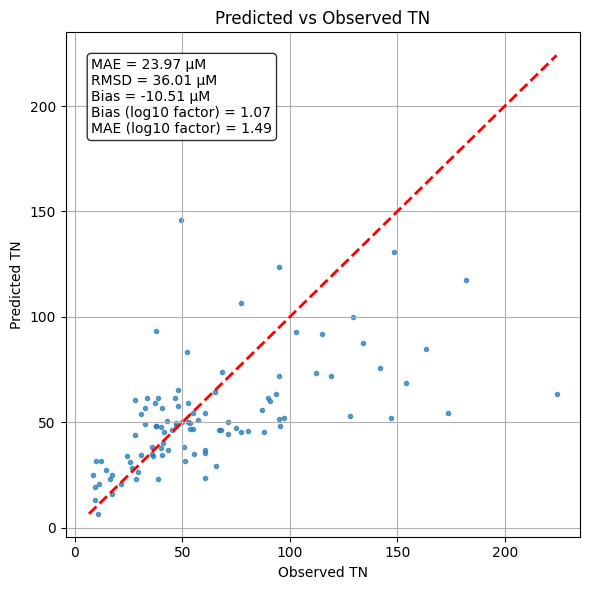

In [ ]:
# 1. Predicted values
predicted = np.median(estimates, axis=0)

# 2. Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, predicted, marker='.', alpha=0.7)
plt.xlabel('Observed TN')
plt.ylabel('Predicted TN')
plt.title('Predicted vs Observed TN')

# 3. 1:1 line
min_val = min(y_test.min(), predicted.min())
max_val = max(y_test.max(), predicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# 4. Compute metrics
# Linear-space metrics
res_lin = y_test - predicted
mae_lin = np.mean(np.abs(res_lin))                  # mean absolute error in TN units
rmsd_lin = np.sqrt(np.mean(res_lin**2))             # root mean squared difference in TN units
bias_lin = np.mean(predicted - y_test)              # additive bias in TN units

residuals_log = np.log10(y_test) - np.log10(predicted)
bias_log = 10**(residuals_log.mean())                     # Bias in the log space
mae_log = 10**(np.abs(residuals_log).mean())              # MAE in the log space

# 5. Add metrics to the plot
plt.text(0.05, 0.95,
         f'MAE = {mae_lin:.2f} µM\nRMSD = {rmsd_lin:.2f} µM\nBias = {bias_lin:.2f} µM\n'
         f'Bias (log10 factor) = {bias_log:.2f}\nMAE (log10 factor) = {mae_log:.2f}',
         # f'MAE = {mae_lin:.2f} \u00B5M\nRMSD = {rmsd_lin:.2f} \u00B5M\nBias (log10) = {bias_log:.2f}\nMAE (log10) = {mae_log:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True)
plt.tight_layout()

# ✅ Save figure before showing
plt.savefig("Predicted_vs_Observed_TN.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Check if TN is already back transformed after MDN run
print("y_test min/max:", y_test.min(), y_test.max())
print("predicted min/max:", predicted.min(), predicted.max())


y_test min/max: 9.921484654 152.0342612
predicted min/max: 10.165858268737793 126.26335144042969
